## Lab 3-1: Image Classification
In this lab, we are going to explore a few options for training model for classifying an image.
We will use [17 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/) throughout this lab.

First, we will mount the dataset to this notebook.
Add this zip file to your google drive (by clicking google drive symbol on the top-right) and change the unzip path accordingly: https://drive.google.com/open?id=1UCRGAy6hin1Uhsscn150zVvGgKiaePmJ

The following command will mount your google drive to the local machine this notebook is running on. Authorize the mounting and then unzip the dataset. 

It should take a while to unzip.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
!unzip '/content/gdrive/My Drive/lab3-nvidia-chula.zip'


  inflating: dataset/lab3-2/images/pomeranian_112.jpg  
  inflating: dataset/lab3-2/images/newfoundland_147.jpg  
  inflating: dataset/lab3-2/images/basset_hound_189.jpg  
  inflating: dataset/lab3-2/images/scottish_terrier_195.jpg  
  inflating: dataset/lab3-2/images/Siamese_108.jpg  
  inflating: dataset/lab3-2/images/english_setter_128.jpg  
  inflating: dataset/lab3-2/images/german_shorthaired_169.jpg  
  inflating: dataset/lab3-2/images/British_Shorthair_74.jpg  
  inflating: dataset/lab3-2/images/staffordshire_bull_terrier_202.jpg  
  inflating: dataset/lab3-2/images/British_Shorthair_60.jpg  
  inflating: dataset/lab3-2/images/beagle_202.jpg  
  inflating: dataset/lab3-2/images/pomeranian_15.jpg  
  inflating: dataset/lab3-2/images/scottish_terrier_181.jpg  
  inflating: dataset/lab3-2/images/basset_hound_176.jpg  
  inflating: dataset/lab3-2/images/Egyptian_Mau_84.jpg  
  inflating: dataset/lab3-2/images/newfoundland_190.jpg  
  inflating: dataset/lab3-2/images/saint_bernard_1

## Import used python libraries

In [3]:
# Downgrade Pillow to avoid errors
!pip install Pillow==3.4.2

import tensorflow as tf
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras import optimizers 
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from time import time

from numpy.random import seed
seed(12)
from tensorflow import set_random_seed
set_random_seed(12)

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12)

from sklearn.metrics import classification_report, f1_score, accuracy_score
import glob
from tqdm import tqdm
import warnings

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    100% |████████████████████████████████| 10.8MB 2.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/aa/61/8d/0e7f809bf0bb469baec6bd5cc32838cdc1e25a805b2b1b4d8f
Successfully built Pillow
torchvision 0.2.2.post3 has requirement pillow>=4.1.1, but you'll have pillow 3.4.2 which is incompatible.
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
bokeh 1.0.4 has requirement pillow>=4.0, but you'll have pillow 3.4.2 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


Using TensorFlow backend.


## Variable path Setting
- training, validation, testing and model path directories.

In [0]:
train_dir = "./dataset/lab3-1/10_flower/train"
val_dir = "./dataset/lab3-1/10_flower/validate"
test_dir = "./dataset/lab3-1/10_flower/test"

## Data preprocessing

Read training and validation dataset
- Data augmentation strategies using ImageDataGenerator

In [5]:
image_size = 224
num_class = 10

batch_size=32

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
 
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode='categorical')

Found 480 images belonging to 10 classes.
Found 160 images belonging to 10 classes.


In [0]:
x, y = train_generator.next()

## Modeling

Define Base model (pre-trained model)
- `VGG19` model with weights pre-trained on `ImageNet`, cited by: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
- and These weights are ported from the ones released by VGG at Oxford under the Creative Commons Attribution License.

We can start with these pretrained weights when training on our new task, __fine-tuning technique__, and the initial neural network is used only as a feature extractor. That means that we freeze every layer prior to the output layer and simply learn a new output layer.

To fine-tune a network, we must first replace the last fully-connected layer with a new one that outputs the desired number of classes. We initialize its weights randomly. Then we continue training as normal. Sometimes it’s common to use a smaller learning rate based on the intuition that we may already be close to a good result.

In this demonstration, we’ll fine-tune a model pretrained on `VGG19` to the smaller target task and training the model with checkpoint and early stopping callbacks.

Define f1_score metric for evaluating model 

In [0]:
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

## Model 1
- VGG19 (random initialized weights) + 2 Dense layers + Output layer

In [11]:
base_model = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=0, mode='max')

model_1_path = "./model/lab3_1/{}.h5".format("model_1")
checkpoint = ModelCheckpoint(model_1_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_1 = Model(inputs=base_model.input, outputs=output)
model_1.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.0001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_1_path = "./model/const_models/lab3_1/model_1.h5"
model_1.load_weights(pretrined_model_1_path)

## Run until early stopping
num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
model_1.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=5,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
8/7 [================================] - 24s 3s/step - loss: 0.4671 - acc: 0.8203 - f1_score_metric: 0.7695 - val_loss: 1.3465 - val_acc: 0.6250 - val_f1_score_metric: 0.5833

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to ./model/lab3_1/model_1.h5
Epoch 2/5
8/7 [================================] - 9s 1s/step - loss: 0.4295 - acc: 0.8789 - f1_score_metric: 0.8398 - val_loss: 1.5892 - val_acc: 0.6562 - val_f1_score_metric: 0.6354

Epoch 00002: val_acc improved from 0.62500 to 0.65625, saving model to ./model/lab3_1/model_1.h5
Epoch 3/5
8/7 [================================] - 9s 1s/step - loss: 0.3454 - acc: 0.8789 - f1_score_metric: 0.8594 - val_loss: 0.8253 - val_acc: 0.6979 - val_f1_score_metric: 0.6667

Epoch 00003: val_a

## Model 2
- VGG (pre-trained weights) + 2 Dense layers + Output layer
- Freezes all weights of base model layers

In [12]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=20, verbose=0, mode='max')

model_2_path = "./model/lab3_1/{}.h5".format("model_2")
checkpoint = ModelCheckpoint(model_2_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_2 = Model(inputs=base_model.input, outputs=output)
model_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.0001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_2_path = "./model/const_models/lab3_1/model_2.h5"
model_2.load_weights(pretrined_model_2_path)

## Run until early stopping
num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
model_2.fit_generator(
        train_generator,
        steps_per_epoch=stepsPerEpoch,
        epochs=5,
        callbacks = callbacks_list,
        validation_data = validation_generator,
        validation_steps=validationSteps
        )

80142336/80134624 [==============================] - 3s 0us/step
Epoch 1/5
8/7 [================================] - 8s 1s/step - loss: 2.2135 - acc: 0.8555 - f1_score_metric: 0.8555 - val_loss: 3.4015 - val_acc: 0.7604 - val_f1_score_metric: 0.7604

Epoch 00001: val_acc improved from -inf to 0.76042, saving model to ./model/lab3_1/model_2.h5
Epoch 2/5
8/7 [================================] - 4s 541ms/step - loss: 2.9732 - acc: 0.8086 - f1_score_metric: 0.8086 - val_loss: 3.1828 - val_acc: 0.7812 - val_f1_score_metric: 0.7812

Epoch 00002: val_acc improved from 0.76042 to 0.78125, saving model to ./model/lab3_1/model_2.h5
Epoch 3/5
8/7 [================================] - 6s 700ms/step - loss: 2.0908 - acc: 0.8633 - f1_score_metric: 0.8633 - val_loss: 3.4173 - val_acc: 0.7708 - val_f1_score_metric: 0.7708

Epoch 00003: val_acc did not improve from 0.78125
Epoch 4/5
8/7 [================================] - 6s 706ms/step - loss: 2.6712 - acc: 0.8203 - f1_score_metric: 0.8203 - val_loss: 3

## Model 3
- VGG19 (pre-trained weights) + 2 Dense layers + Output layer
- use basic Fine-tuning technique which unfreezes all layers.

In [13]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=0, mode='max')

model_3_path = "./model/lab3_1/{}.h5".format("model_3")
checkpoint = ModelCheckpoint(model_3_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint,early_stopper,reduce_lr]

# Create and compile model
model_3 = Model(inputs=base_model.input, outputs=output)
model_3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.00001),metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_3_path = "./model/const_models/lab3_1/model_3.h5"
model_3.load_weights(pretrined_model_3_path)

## Run until early stopping
num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size
history = model_3.fit_generator(
                    train_generator,
                    steps_per_epoch=stepsPerEpoch,
                    epochs=5,
                    callbacks = callbacks_list,
                    validation_data = validation_generator,
                    validation_steps=validationSteps
                    )

Epoch 1/5
8/7 [================================] - 15s 2s/step - loss: 0.2700 - acc: 0.9297 - f1_score_metric: 0.9219 - val_loss: 0.5684 - val_acc: 0.8542 - val_f1_score_metric: 0.8542

Epoch 00001: val_acc improved from -inf to 0.85417, saving model to ./model/lab3_1/model_3.h5
Epoch 2/5
8/7 [================================] - 9s 1s/step - loss: 0.2712 - acc: 0.9141 - f1_score_metric: 0.9102 - val_loss: 0.5640 - val_acc: 0.8438 - val_f1_score_metric: 0.8229

Epoch 00002: val_acc did not improve from 0.85417
Epoch 3/5
8/7 [================================] - 9s 1s/step - loss: 0.1910 - acc: 0.9375 - f1_score_metric: 0.9258 - val_loss: 0.4224 - val_acc: 0.8854 - val_f1_score_metric: 0.8542

Epoch 00003: val_acc improved from 0.85417 to 0.88542, saving model to ./model/lab3_1/model_3.h5
Epoch 4/5
8/7 [================================] - 9s 1s/step - loss: 0.2061 - acc: 0.9375 - f1_score_metric: 0.9297 - val_loss: 0.6900 - val_acc: 0.8021 - val_f1_score_metric: 0.7917

Epoch 00004: val_a

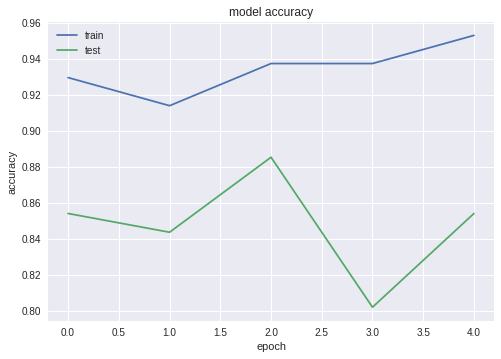

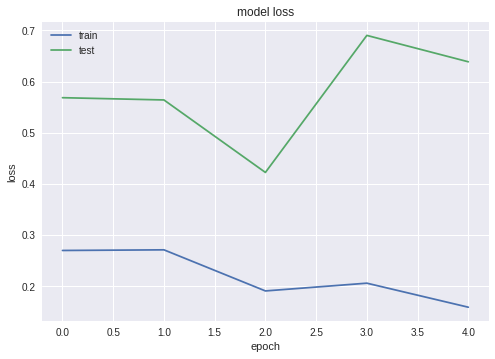

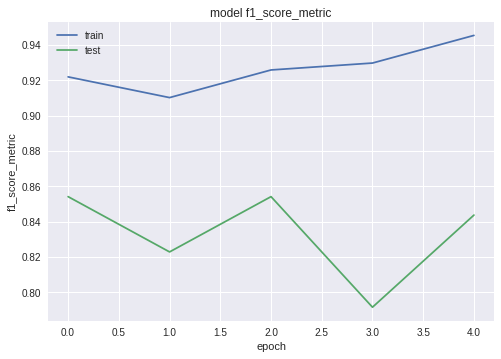

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for f1_score
plt.plot(history.history['f1_score_metric'])
plt.plot(history.history['val_f1_score_metric'])
plt.title('model f1_score_metric')
plt.ylabel('f1_score_metric')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 4
- VGG (pre-trained weights) + 2 Dense layers + Output layer
- use `Chain-thaw` Fine-tuning technique, referenced by [Using millions of emoji occurrences to learn any-domain representations for detecting sentiment, emotion and sarcasm](https://arxiv.org/pdf/1708.00524.pdf).

In [0]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024)(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Create  model
model_4 = Model(inputs=base_model.input, outputs=output)

num_training_img=240
num_validation_img=80
stepsPerEpoch = num_training_img/batch_size
validationSteps= num_validation_img/batch_size

base_model_layers = model_4.layers[:23]
new_model_layers =  model_4.layers[23:]

base_model_blocks = {
    0: base_model_layers[1:3],
    1: base_model_layers[4:6],
    2: base_model_layers[7:11],
    3: base_model_layers[12:16],
    4: base_model_layers[17:21]
}

In [0]:
# print("\n--[Phase 1]--: Train only new layers")

# for layer in base_model_layers:
#     layer.trainable = False

# # Callbacks
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=10,
#                                 verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
# early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
#                            patience=25, verbose=0, mode='max')

# model_4_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_1/{}.h5".format("model_4_1")))
# checkpoint = ModelCheckpoint(model_4_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
# callbacks_list = [checkpoint,early_stopper,reduce_lr]
    
# model_4.compile(loss="categorical_crossentropy",
#               optimizer=optimizers.Adam(lr=0.0001), metrics=["accuracy", f1_score_metric])

# model_4.fit_generator(
#     train_generator,
#     steps_per_epoch=stepsPerEpoch,
#     epochs=50,
#     callbacks=callbacks_list,
#     validation_data=validation_generator,
#     validation_steps=validationSteps
#     )

In [0]:
# print("\n--[Phase 2]--: Train every CNN blocks of base model (5 blocks)")

# model_4_prev_path = os.path.abspath(os.path.join(curr_dir, "./model/const_models/lab3_1/model_4_1.h5"))
# print("Loading the previous weight from {}.".format(model_4_prev_path))
# model_4.load_weights(model_4_prev_path)

# for layer in new_model_layers:
#     layer.trainable = False

# for idx in range(0, 5):
#     # train idx block
#     print("[Train block{}]: containing {} layers".format(idx, len(base_model_blocks[idx])))
    
#     # Callbacks
#     reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max', factor=0.1, patience=4,
#                                     verbose=1, min_delta=0.0001, cooldown=2, min_lr=0)
#     early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, 
#                                patience=10, verbose=0, mode='max')

#     model_4_path = os.path.abspath(os.path.join(curr_dir, f"./model/const_models/lab3_1/model_4_2_{idx}.h5"))
#     checkpoint = ModelCheckpoint(model_4_path, monitor='val_acc', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
#     callbacks_list = [checkpoint,early_stopper,reduce_lr]

#     for layer in base_model_layers:
#         if layer in base_model_blocks[idx]:
#             layer.trainable = True
#             print("train {}".format(layer))
#         else:
#             layer.trainable = False
#     model_4.compile(loss="categorical_crossentropy",
#                   optimizer=optimizers.Adam(lr=0.000001), metrics=["accuracy", f1_score_metric])
#     model_4.fit_generator(
#         train_generator,
#         steps_per_epoch=stepsPerEpoch,
#         epochs=50,
#         callbacks=callbacks_list,
#         validation_data=validation_generator,
#         validation_steps=validationSteps
#     )

## `To do` 

You are supposed to implement `Chain-thaw` Fine-tuning technique in the last phase which is to unfreeze all of model layers and train it to be well adapted to the target task.

HINT: you should load the last epoch model weights from provided const-model folder before training model with `fit_generator` function from the code below.


```python
pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)
```


Noted that there are still needs for both `ModelCheckpoint` callback, saving model to the path, and `EarlyStopping` is still required.

The solution can be seen in the cell below.

In [19]:
print("--[Phase 3]--: Train all layers")
for layer in model_4.layers:
    layer.trainable = True

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score_metric', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_f1_score_metric', min_delta=0, 
                           patience=30, verbose=0, mode='max')
model_4_path = "./model/lab3_1/{}.h5".format("model_4")
checkpoint = ModelCheckpoint(model_4_path, monitor='val_f1_score_metric', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]

model_4.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.00001), metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)

model_4.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=5,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=validationSteps
)

--[Phase 3]--: Train all layers
Epoch 1/5
8/7 [================================] - 15s 2s/step - loss: 0.7555 - acc: 0.9531 - f1_score_metric: 0.9531 - val_loss: 2.0148 - val_acc: 0.8750 - val_f1_score_metric: 0.8750

Epoch 00001: val_f1_score_metric improved from -inf to 0.87500, saving model to ./model/lab3_1/model_4.h5
Epoch 2/5
8/7 [================================] - 9s 1s/step - loss: 0.3725 - acc: 0.9727 - f1_score_metric: 0.9727 - val_loss: 1.5692 - val_acc: 0.8958 - val_f1_score_metric: 0.8958

Epoch 00002: val_f1_score_metric improved from 0.87500 to 0.89583, saving model to ./model/lab3_1/model_4.h5
Epoch 3/5
8/7 [================================] - 9s 1s/step - loss: 0.9094 - acc: 0.9375 - f1_score_metric: 0.9375 - val_loss: 2.2222 - val_acc: 0.8542 - val_f1_score_metric: 0.8542

Epoch 00003: val_f1_score_metric did not improve from 0.89583
Epoch 4/5
8/7 [================================] - 9s 1s/step - loss: 1.2243 - acc: 0.9180 - f1_score_metric: 0.9180 - val_loss: 2.9674

<details>
    <summary>SOLUTION HERE!</summary>
    <pre>
        <code>

for layer in model_4.layers:
    layer.trainable = True

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score_metric', mode='max', factor=0.1, patience=10,
                                verbose=1, min_delta=0.0001, cooldown=5, min_lr=0)
early_stopper = EarlyStopping(monitor='val_f1_score_metric', min_delta=0, 
                           patience=30, verbose=0, mode='max')
model_4_path = "./model/lab3_1/{}.h5".format("model_4")
checkpoint = ModelCheckpoint(model_4_path, monitor='val_f1_score_metric', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
callbacks_list = [checkpoint, early_stopper, reduce_lr]

model_4.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=0.00001), metrics=["accuracy", f1_score_metric])

# Load last epoch model
pretrined_model_4_path = "./model/const_models/lab3_1/model_4_3.h5"
model_4.load_weights(pretrined_model_4_path)

model_4.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=5,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=validationSteps
)
        </code>
    </pre>
</details>

## Evaluation
-  `F-score` is really useful if you want to compare 2 classifiers. It is computed using the harmonic mean of precision and recall, and gives much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high. You can easily compute the F-Score with sklearn.
- `Micro F1-score` is to calculate metrics globally by counting the total true positives, false negatives and false positives, while 
- `Macro F1-score` is to calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [0]:
class_to_idx = train_generator.class_indices
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [21]:
idx_to_class

{0: 'class_1',
 1: 'class_10',
 2: 'class_2',
 3: 'class_3',
 4: 'class_4',
 5: 'class_5',
 6: 'class_6',
 7: 'class_7',
 8: 'class_8',
 9: 'class_9'}

In [0]:
# Load the best model
model_1_path = "./model/lab3_1/{}.h5".format("model_1")
model_2_path = "./model/lab3_1/{}.h5".format("model_2")
model_3_path = "./model/lab3_1/{}.h5".format("model_3")
model_4_path = "./model/lab3_1/{}.h5".format("model_4")

model_1.load_weights(model_1_path)
model_2.load_weights(model_2_path)
model_3.load_weights(model_3_path)
model_4.load_weights(model_4_path)

In [23]:
# Prepare in case of problem
# model.load(model_path)

idx_to_model = {
    1: model_1,
    2: model_2,
    3: model_3,
    4: model_4
}
idx_to_preds = {
    1: ([], []), # y_trues, y_preds
    2: ([], []),
    3: ([], []),
    4: ([], [])
}

for class_idx in tqdm(range(num_class)):
    label = idx_to_class[class_idx]
    file_list = glob.glob("{}/{}/*.jpg".format(test_dir, label))
    for raw_image in file_list:
        inputShape = (224,224) # Assumes 3 channel image
        image = load_img(raw_image, target_size=inputShape)
        image = img_to_array(image)   # shape is (224,224,3)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)  # Now shape is (1,224,224,3)

        for model_idx in range(1, 5):
            model = idx_to_model[model_idx]
            preds = model.predict(image)
            pred_class = np.argmax(preds)

            # append y_trues
            idx_to_preds[model_idx][0].append(class_idx)
            # append y_preds
            idx_to_preds[model_idx][1].append(pred_class)

100%|██████████| 10/10 [00:23<00:00,  2.15s/it]


In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Performace of each models:")
    for idx in range(1, 5):
      
        y_trues = idx_to_preds[idx][0]
        y_preds = idx_to_preds[idx][1]
        print("-- Model_{} (acc:{:.4f}, f1_micro:{:.4f}, f1_macro:{:.4f})".format(idx,
                                                                                accuracy_score(y_trues, y_preds), 
                                                                                f1_score(y_trues, y_preds, average='micro'),
                                                                                f1_score(y_trues, y_preds, average='macro')))

Performace of each models:
-- Model_1 (acc:0.5938, f1_micro:0.5938, f1_macro:0.5883)
-- Model_2 (acc:0.7125, f1_micro:0.7125, f1_macro:0.6673)
-- Model_3 (acc:0.7937, f1_micro:0.7937, f1_macro:0.7930)
-- Model_4 (acc:0.8000, f1_micro:0.8000, f1_macro:0.8074)


## Result
to see how the model perform by testing sample visualized by matplotlib.

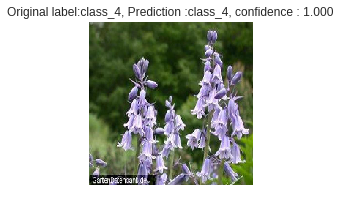

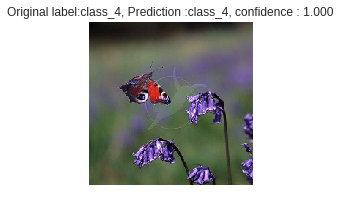

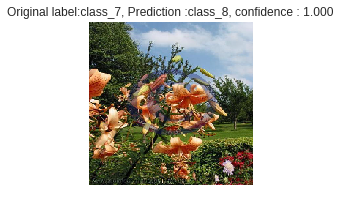

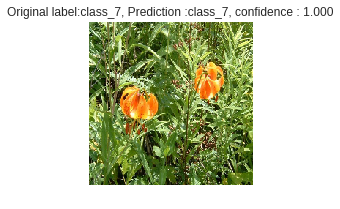

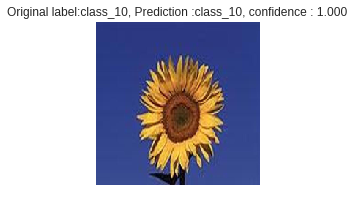

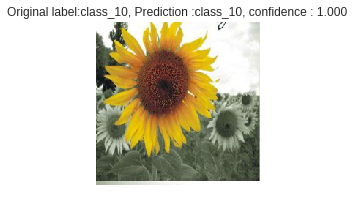

In [25]:
import random

for class_idx in random.sample(range(0, num_class), 3):
    label = idx_to_class[class_idx]
    file_list = glob.glob("{}/{}/*.jpg".format(test_dir, label))
    for raw_image in file_list[:2]:
        inputShape = (224,224)
        image = load_img(raw_image, target_size=inputShape)
        image = img_to_array(image)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        preds = model_4.predict(image)

        pred_class = np.argmax(preds)
        pred_label = idx_to_class[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            label,
            pred_label,
            preds[0][pred_class])

        original = load_img(raw_image, target_size=(224, 224))
        plt.figure(figsize=[3,3])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()